In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#individual layers from keras
from tensorflow.keras.layers import Conv1D, LeakyReLU, GaussianNoise
from tensorflow.keras import ops

print(tf.config.list_physical_devices('GPU'))


2024-11-13 09:35:55.443445: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 09:35:55.666624: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731508555.749483     987 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731508555.780374     987 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 09:35:56.021233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<b> Network architecture from Tarabanis et al. https://doi.org/10.1016/j.jacep.2022.09.021</b>


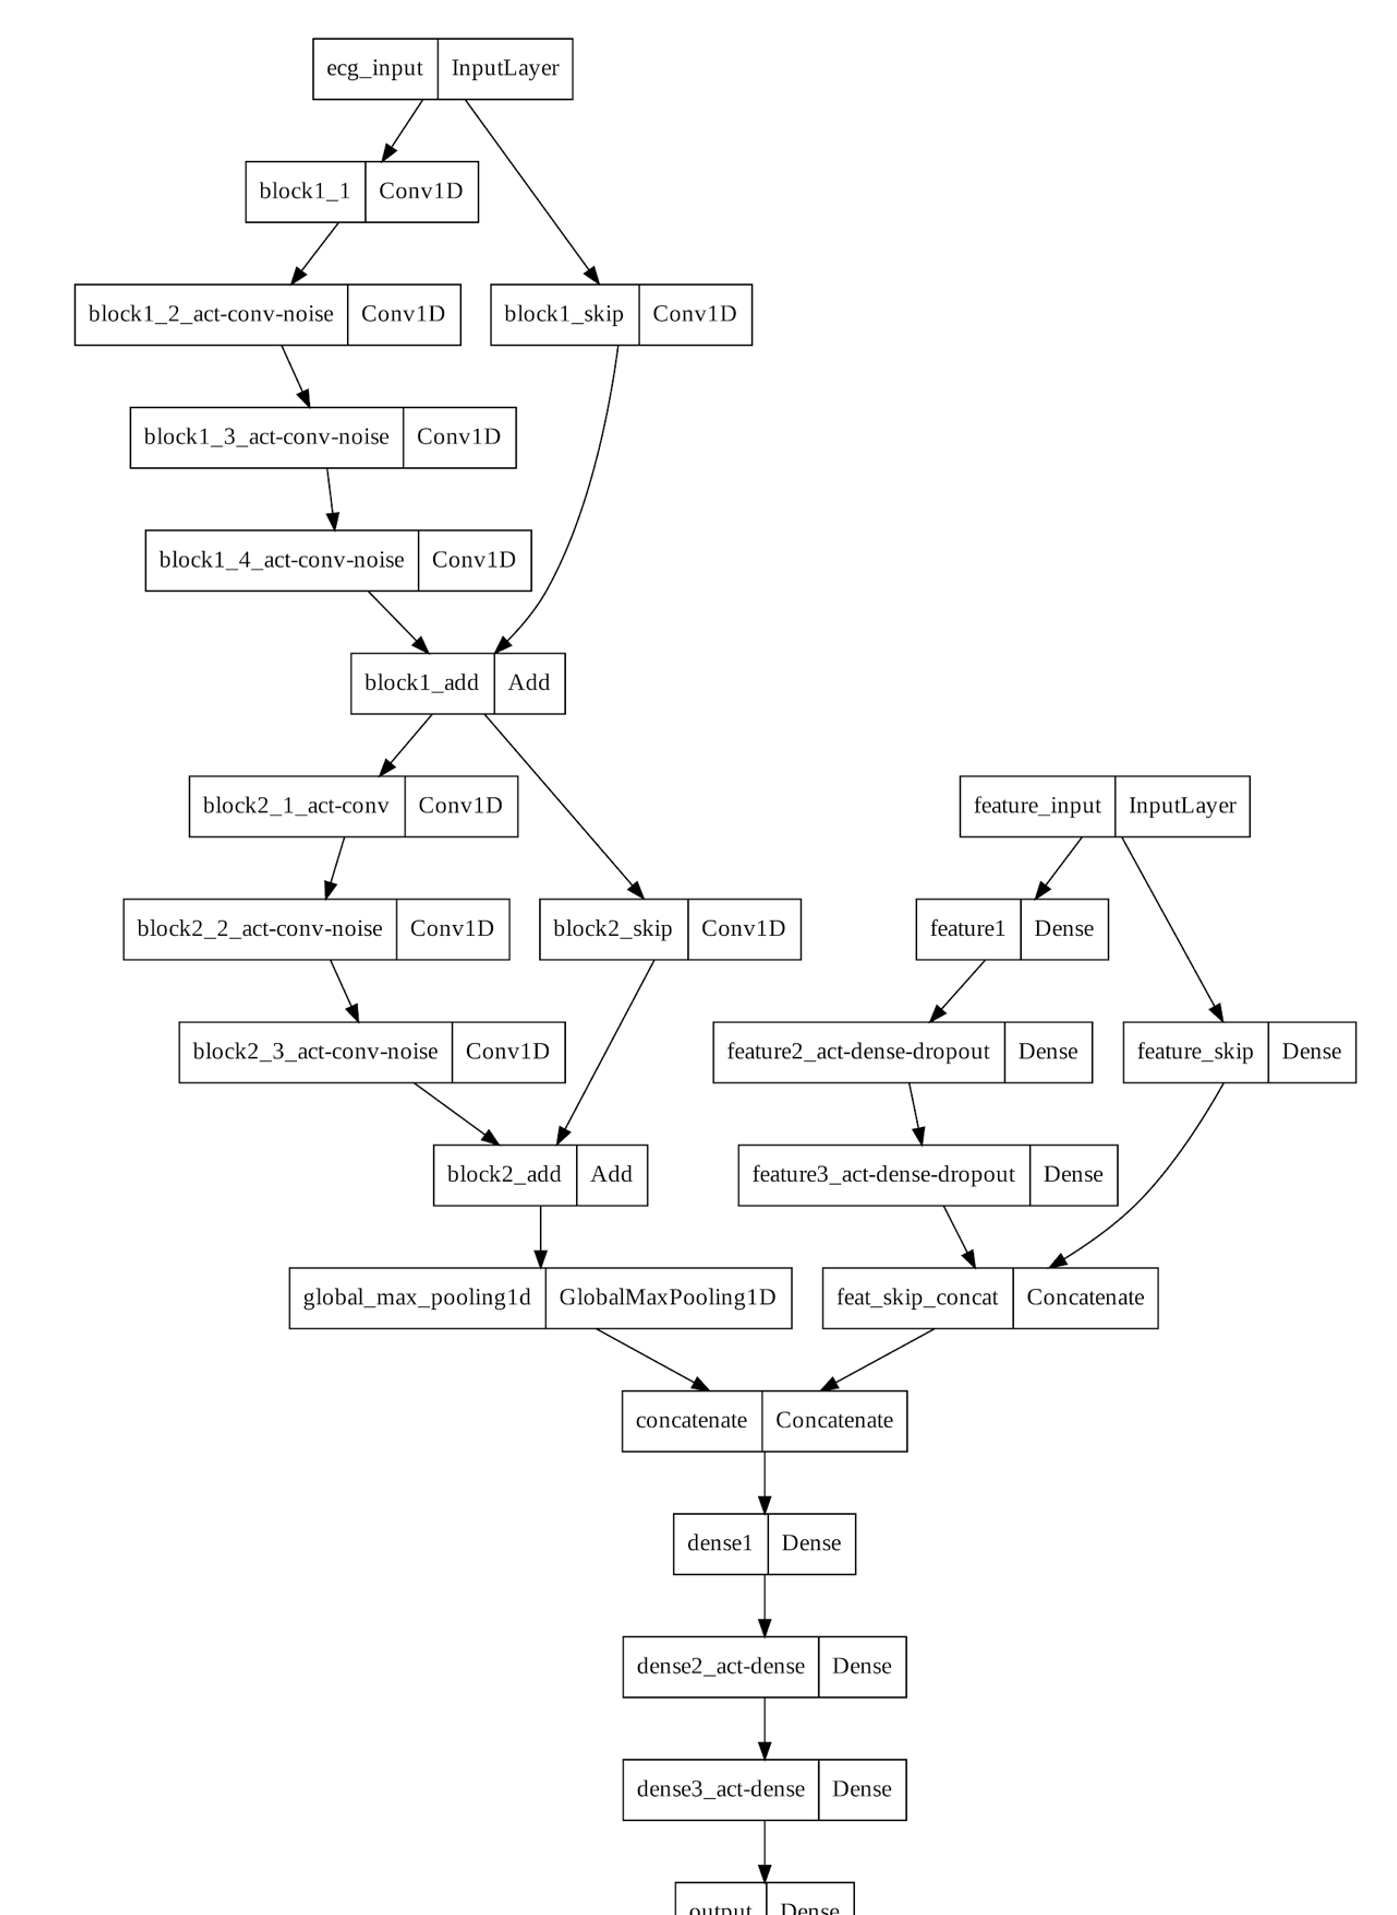



In [10]:
# Define the block layers of CNN - use functional API to implement residuals

#input layer (1250 time samples x 12 ECG channels)
time_samples = 1250
channels = 12

#Input to L-side of model (ecg channels)
ecg_inputs = keras.Input(shape=(time_samples, channels))

#convolution_params
conv_kernel_size = 56
conv_filter_size = 128
conv_dilation_rate = 3

#noise params
gauss_noise_stdev = 0.0013

#Block 1_1 - 1D convolution
b1_conv1D_1 = Conv1D(
    filters=conv_filter_size, 
    kernel_size=conv_kernel_size,
    dilation_rate=conv_dilation_rate)(ecg_inputs)

#will need to modify function below to autofill hyperparameters later in development
#act-conv_noise generic reusuable block
def act_conv_noise(inputs, block_name='ActConvNoise'):
    #include in network flow graph
    with tf.name_scope(block_name):
        #activation params
        leaky_relu_alpha = 0.20631

        #convolution_params
        conv_kernel_size = 56
        conv_filter_size = 128
        conv_dilation_rate = 3
        gauss_noise_stdev = 0.0013

        #activation
        act = LeakyReLU(negative_slope=leaky_relu_alpha)(inputs)

        #convolution
        conv = Conv1D(filters=conv_filter_size, 
                    kernel_size=conv_kernel_size,
                    dilation_rate=conv_dilation_rate)(act)
        
        #noise
        output_layer = GaussianNoise(stddev=gauss_noise_stdev)(conv)
        return output_layer

In [13]:
#Arrange the layers into unified network

#block 1_1
b1_conv1D_1
#block 1_2
b1_act_conv_noise_2 = act_conv_noise(b1_conv1D_1, 'block1_2')
#block 1_3
b1_act_conv_noise_3 = act_conv_noise(b1_act_conv_noise_2, 'block1_3')
#block 1_4
b1_act_conv_noise_4 = act_conv_noise(b1_act_conv_noise_3, 'block1_4')


Model: "ecg_QTC_buprop_level_predict"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1250, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1085, 128)      │        86,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1085, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 920, 128)       │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ (None, 920, 128)       │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 920, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 755, 128)       │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_4                │ (None, 755, 128)       │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 755, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 590, 128)       │       917,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_5                │ (None, 590, 128)       │             0 │
│ (GaussianNoise)                 │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,839,040 (10.83 MB)

 Trainable params: 2,839,040 (10.83 MB)

 Non-trainable params: 0 (0.00 B)

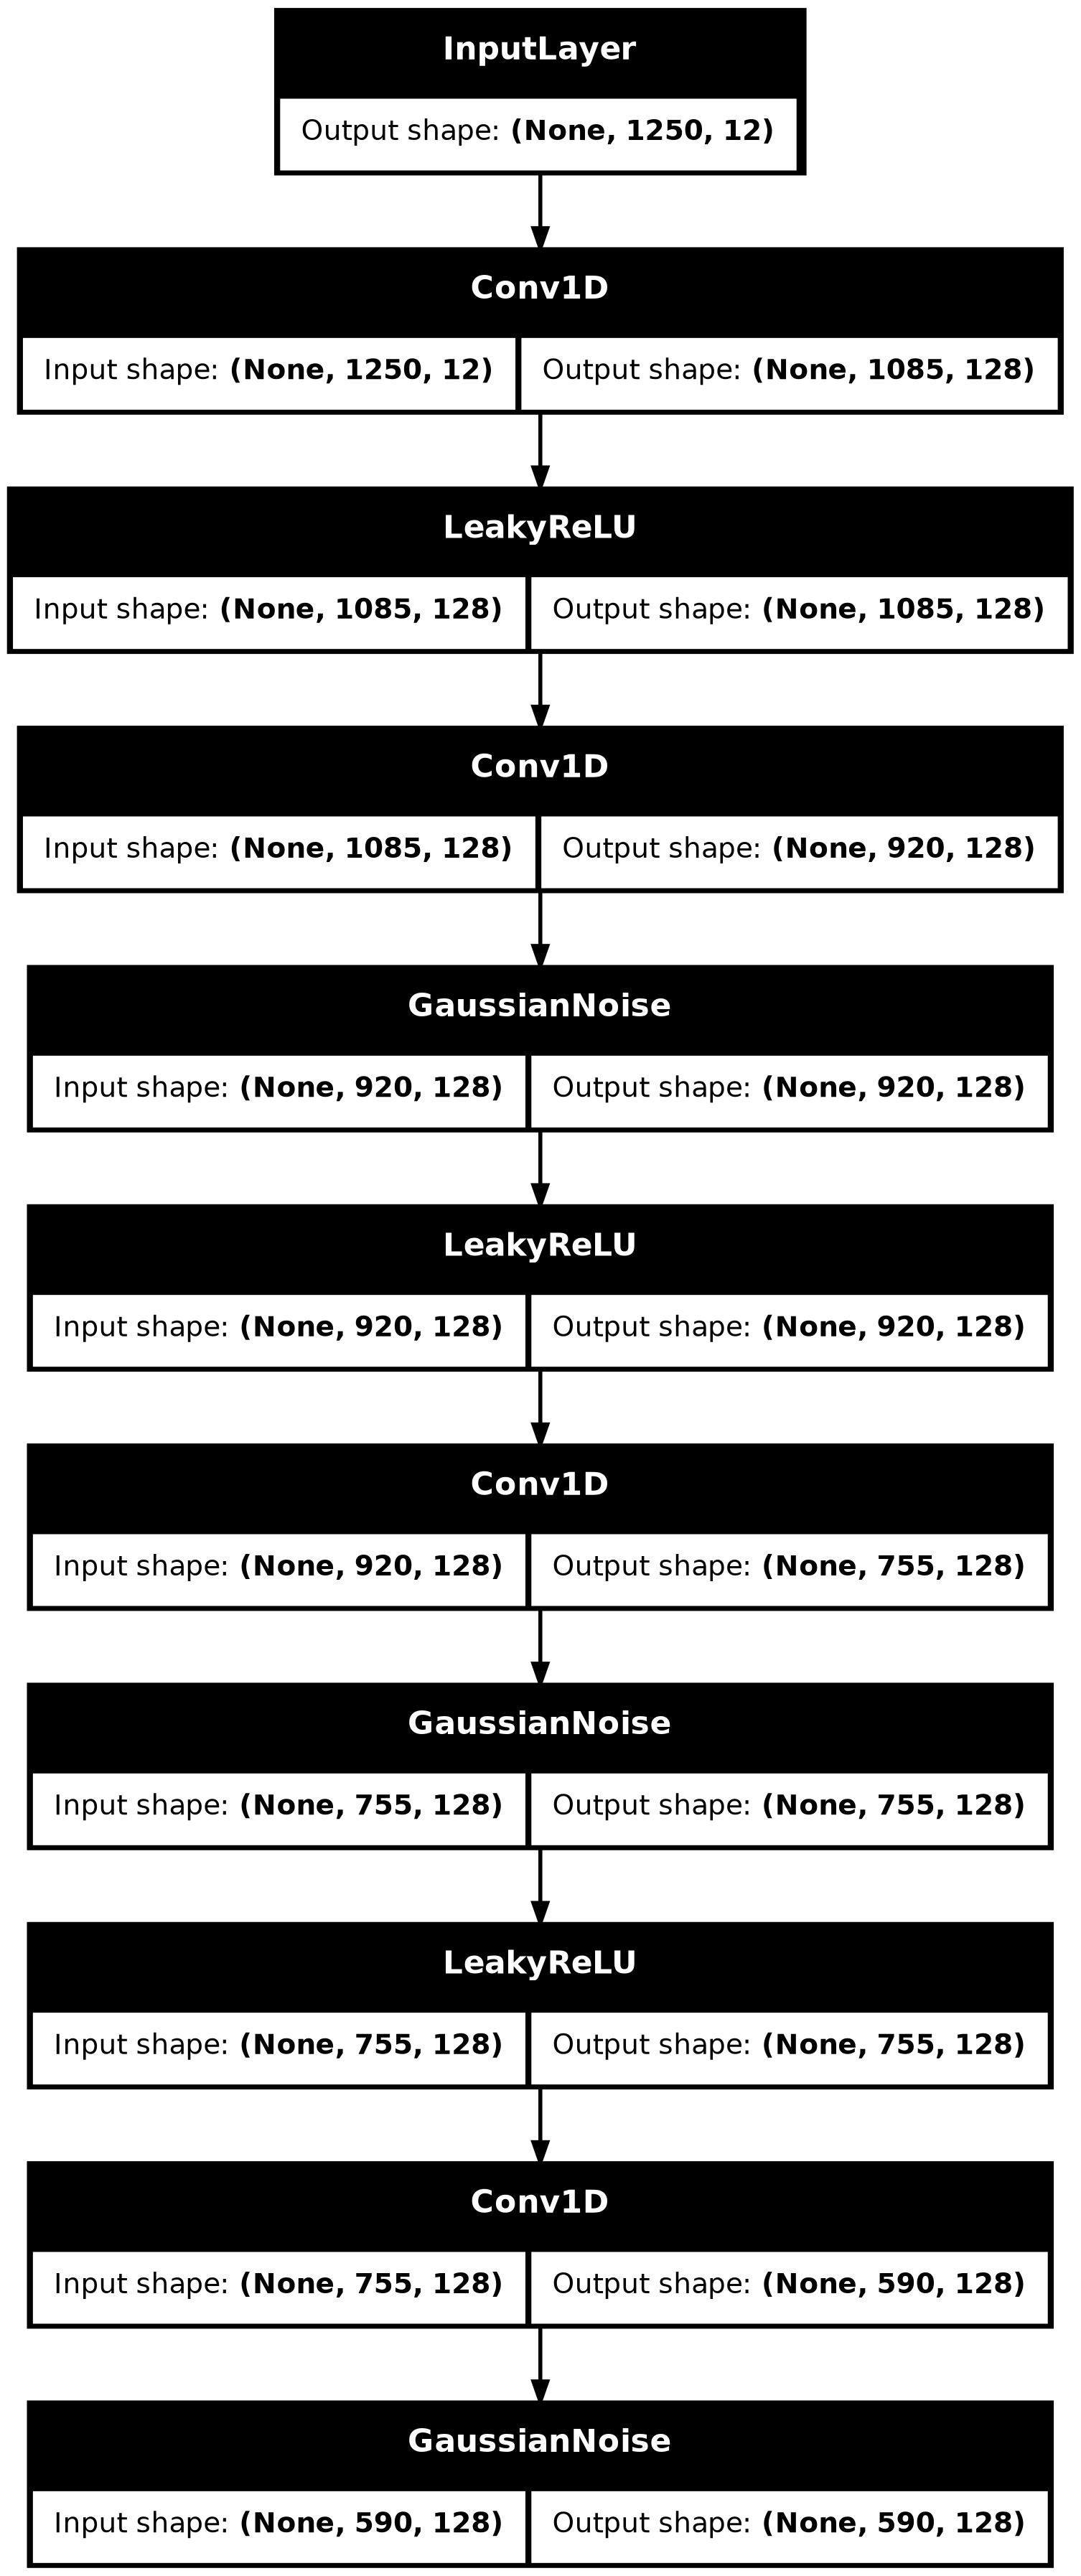

In [18]:
#Define the model and plot the model tree
model = keras.Model(inputs=ecg_inputs, outputs=b1_act_conv_noise_4, name="ecg_QTC_buprop_level_predict")

model.summary()
keras.utils.plot_model(model, "ecg_QTC_buprop_level_predi.png", show_shapes=True)